# Physics-informed microphysics neural network emulator

David John Gagne

The goal of this approach is to include more physical constraints and make the training easier for the microphysics emulator. 

The physics-informed neural network setup integrates the following components.

1. Predict the updated microphysical terms rather than tendencies. The tendencies have very weird distributions that are hard for one neural network to fit. The original values on the other hand are all greater than 0, so it is easier to ensure that outputs are always greater than 0 this way.
$y_{new} = y_{old} + y_{tend} dt$

$dt=1800 \text{ s}$

2. Keep all inputs and outputs in log space for training ideally.

3. Enforce mass conservation between cloud and rain. 
$ q_{ro} + q_{co} = q_{rn} + q_{cn}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from glob import glob
from os.path import join
import xarray as xr
import dask.dataframe as dd
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
%matplotlib inline

In [2]:
mp_csv_path = "/glade/p/cisl/aiml/dgagne/cam_mp_files_run5_full_csv/"
mp_csv_files = sorted(glob(join(mp_csv_path, "*.csv")))

In [3]:
mp_data = pd.concat([pd.read_csv(mp_csv_files[x]) for x in range(0, 400, 20)], ignore_index=True)

In [4]:
mp_data.columns

Index(['Index', 'lat', 'lev', 'lon', 'P0', 'PS', 'depth', 'row', 'col', 'hyam',
       'hybm', 'pressure', 'temperature', 'RHO_CLUBB_lev', 'RHO_CLUBB_top',
       'RHO_CLUBB_bottom', 'QC_TAU_in', 'NC_TAU_in', 'QR_TAU_in', 'NR_TAU_in',
       'lamc', 'lamr', 'lcldm', 'n0r', 'pgam', 'precip_frac', 'qctend_MG2',
       'qctend_TAU', 'nctend_MG2', 'nctend_TAU', 'qrtend_MG2', 'qrtend_TAU',
       'nrtend_MG2', 'nrtend_TAU', 'time'],
      dtype='object')

In [5]:
dt = 60 * 30 #minutes
for var in ["QC", "QR", "NC", "NR"]:
    mp_data[var + "_TAU_out"] = (mp_data[var + "_TAU_in"] +  mp_data[var.lower() + "tend_TAU"] * dt)
    mp_data[var + "_MG2_out"] = (mp_data[var + "_TAU_in"] +  mp_data[var.lower() + "tend_MG2"] * dt)

In [6]:
mp_data["mass_diff_TAU"] = (mp_data["QC_TAU_out"] + mp_data["QR_TAU_out"]) - (mp_data["QC_TAU_in"] + mp_data["QR_TAU_in"])
mp_data["mass_diff_MG2"] = (mp_data["QC_MG2_out"] + mp_data["QR_MG2_out"]) - (mp_data["QC_TAU_in"] + mp_data["QR_TAU_in"])

In [7]:
mp_data["tend_diff_TAU"] = (mp_data["qctend_TAU"] + mp_data["qrtend_TAU"])
mp_data["tend_diff_MG2"] = (mp_data["qctend_MG2"] + mp_data["qrtend_MG2"])

In [11]:
np.count_nonzero((mp_data["tend_diff_TAU"] == 0) & (mp_data["mass_diff_TAU"] == 0) & 
                 np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)) / mp_data.shape[0]

0.5634467095451523

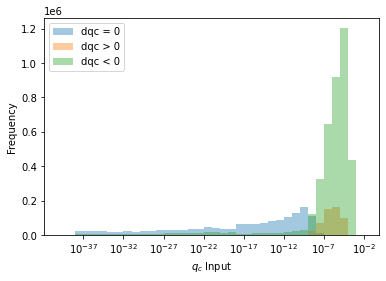

In [10]:
tz = mp_data["qctend_TAU"]== 0
tp = mp_data["qctend_TAU"]> 0
tn = mp_data["qctend_TAU"] < 0


#plt.hist(mp_data["QC_TAU_in"], bins=10. ** np.arange(-40., -1))
plt.hist(mp_data["QC_TAU_in"][tz], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqc = 0")
plt.hist(mp_data["QC_TAU_in"][tp], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqc > 0")
plt.hist(mp_data["QC_TAU_in"][tn], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqc < 0")

plt.gca().set_xscale("log")
plt.xlabel("$q_c$ Input")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("qc_tendency_properties.png")
#plt.gca().set_yscale("log")

In [ ]:
tz = mp_data["qrtend_TAU"]== 0
tp = mp_data["qrtend_TAU"]> 0
tn = mp_data["qrtend_TAU"] < 0


#plt.hist(mp_data["QC_TAU_in"], bins=10. ** np.arange(-40., -1))
plt.hist(mp_data["QR_TAU_in"][tz], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqr = 0")
plt.hist(mp_data["QR_TAU_in"][tp], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqr > 0")
plt.hist(mp_data["QR_TAU_in"][tn], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqr < 0")

plt.gca().set_xscale("log")
plt.xlabel("$q_r$ Input")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("qr_tendency_properties.png")
#plt.gca().set_yscale("log")

In [ ]:
tz = mp_data["qrtend_TAU"]== 0
tp = mp_data["qrtend_TAU"]> 0
tn = mp_data["qrtend_TAU"] < 0


#plt.hist(mp_data["QC_TAU_in"], bins=10. ** np.arange(-40., -1))
plt.hist(mp_data["NR_TAU_in"][tz], bins=10. ** np.arange(-15., 10), alpha=0.4, label="dqr = 0")
plt.hist(mp_data["NR_TAU_in"][tp], bins=10. ** np.arange(-15., 10), alpha=0.4, label="dqr > 0")
plt.hist(mp_data["NR_TAU_in"][tn], bins=10. ** np.arange(-15., 10), alpha=0.4, label="dqr < 0")

plt.gca().set_xscale("log")
plt.xlabel("$N_r$ Input")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("nr_tendency_properties.png")

Test mass conservation (mass diff should be 0). A significant proportion of grid cells have mass conserved

In [9]:
ix = (mp_data["tend_diff_TAU"] == 0) & (mp_data["mass_diff_TAU"] == 0) & np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)
mp_mass_data = mp_data.loc[ix]

In [10]:
mp_mass_data.shape[0] / mp_data.shape[0]

0.5634467095451523

In [12]:
input_cols = ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in"]
output_cols = input_cols[0:2] + ["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]
scale_in = StandardScaler()
in_data = scale_in.fit_transform(np.log10(np.maximum(mp_mass_data[input_cols].values, 1e-38)))
out_data_raw = mp_mass_data[output_cols].values
out_data_log = np.log10(np.maximum(out_data_raw, 1e-38))

In [42]:
(np.log10(1e-6) - np.log10(0.5e-5)) ** 2

0.4885590669614941

In [73]:
from tensorflow.experimental.numpy import log10 as tflog10
def mass_loss(y_true_log, y_pred_log, scale_factor=1):
    
    y_true = 10 ** y_true_log
    y_pred = 10 ** y_pred_log
    mse_loss = tf.reduce_mean((y_true_log - y_pred_log) ** 2, axis=0)
    mass_in_true_l = tflog10(tf.reduce_sum(y_true[:, 0:2], axis=1))
    mass_out_pred_l = tflog10(tf.reduce_sum(y_pred[:, 2:4], axis=1))
    mass_in_pred_l = tflog10(tf.reduce_sum(y_pred[:, 0:2], axis=1))

    mass_diff_loss = tf.reduce_mean((mass_in_true_l - mass_out_pred_l) ** 2)
    mass_diff_loss += tf.reduce_mean((mass_in_true_l - mass_in_pred_l) ** 2)
    loss = tf.reduce_sum(mse_loss) + scale_factor * mass_diff_loss
    loss = tf.reduce_sum(mse_loss)
    return loss

In [74]:
mod = Sequential()
mod.add(Dense(64, input_shape=(len(input_cols),)))
mod.add(Activation("relu"))
mod.add(Dense(16))
mod.add(Activation("relu"))
mod.add(Dense(64))
mod.add(Activation("relu"))
mod.add(Dense(len(output_cols)))

In [93]:
mod.compile(loss=mass_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
mod.fit(in_data, out_data_log, epochs=30, batch_size=4096, verbose=1)

Epoch 1/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0537
Epoch 2/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0544
Epoch 3/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0532
Epoch 4/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0538
Epoch 5/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0535
Epoch 6/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0530
Epoch 7/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0528
Epoch 8/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0526
Epoch 9/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0524
Epoch 10/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0524
Epoch 11/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0520
Epoch 12/30
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0527
E

In [64]:


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
train_dataset = tf.data.Dataset.from_tensor_slices((in_data.astype("float32"), 
                                                    out_data_log.astype("float32")))
for epoch in range(30):
    train_dataset = train_dataset.shuffle(buffer_size=4096).batch(4096)
    print("Epoch", epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            outs = mod(x_batch_train)
            loss_val = mass_loss(y_batch_train, outs)
        grads = tape.gradient(loss_val, mod.trainable_weights)
        optimizer.apply_gradients(zip(grads, mod.trainable_weights))
    print(loss_val)


Epoch 0


KeyboardInterrupt: 

In [65]:
mp_test_data = pd.read_csv(mp_csv_files[600])
dt = 60 * 30 #minutes
for var in ["QC", "QR", "NC", "NR"]:
    mp_test_data[var + "_TAU_out"] = (mp_test_data[var + "_TAU_in"] +  mp_test_data[var.lower() + "tend_TAU"] * dt)
    mp_test_data[var + "_MG2_out"] = (mp_test_data[var + "_TAU_in"] +  mp_test_data[var.lower() + "tend_MG2"] * dt)
mp_test_data["tend_diff_TAU"] = (mp_test_data["qctend_TAU"] + mp_test_data["qrtend_TAU"])
mp_test_data["mass_diff_TAU"] = (mp_test_data["QC_TAU_out"] + mp_test_data["QR_TAU_out"]) - (mp_test_data["QC_TAU_in"] + mp_test_data["QR_TAU_in"])

ixt = (mp_test_data["tend_diff_TAU"] == 0) & (mp_test_data["mass_diff_TAU"] == 0) & \
    np.all(mp_test_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)
mp_test_mass_data = mp_test_data.loc[ixt]

in_test_data = scale_in.transform(np.log10(np.maximum(mp_test_mass_data[input_cols].values, 1e-38)))
out_test_data = np.log10(np.maximum(mp_test_mass_data[output_cols].values, 1e-38))

In [94]:
mod_preds = mod.predict(in_test_data, batch_size=1024)

In [95]:
mod_preds

array([[-37.992645 , -17.70067  , -37.99714  , -17.701494 , -12.003219 ,
         -7.1061244],
       [-37.992645 , -17.70067  , -37.99714  , -17.701494 , -12.003219 ,
         -7.1061244],
       [-37.992645 , -17.70067  , -37.99714  , -17.701494 , -12.003219 ,
         -7.1061244],
       ...,
       [ -4.549213 ,  -6.476517 ,  -4.5744   ,  -6.200406 ,   6.0217943,
          2.9641352],
       [ -4.5491886,  -6.476521 ,  -4.574376 ,  -6.200396 ,   6.0217776,
          2.9641387],
       [ -4.549182 ,  -6.4765215,  -4.57437  ,  -6.2003946,   6.0217695,
          2.9641395]], dtype=float32)

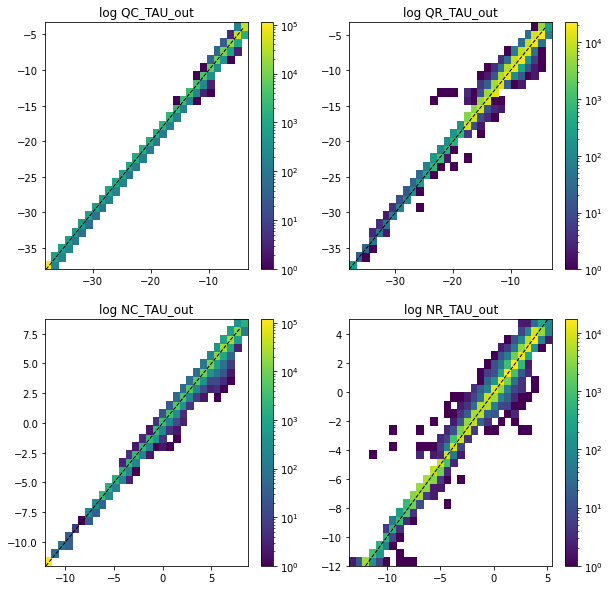

In [96]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist2d(mod_preds[:, i+2], out_test_data[:,i+2], cmin=1, norm=LogNorm(), bins=30)
    plt.title("log " + output_cols[i+2])
    diag = np.arange(out_test_data[:, i+2].min(), out_test_data[:, i+2].max(), 1)
    plt.plot(diag, diag, 'k--', lw=1)
    plt.colorbar()

In [97]:
mod_preds_rescaled =  10 ** mod_preds
out_test_data_rescaled = 10 ** out_test_data

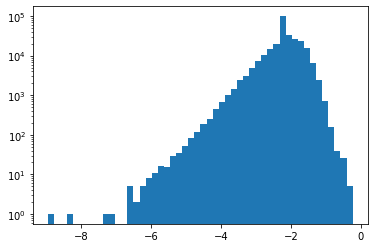

In [102]:
mass_diff = np.log10(mod_preds_rescaled[:, 0:2].sum(axis=1)) - np.log10(out_test_data_rescaled[:, 0:2].sum(axis=1))
plt.hist(np.log10(np.abs(mass_diff)), bins=50)
plt.gca().set_yscale("log")

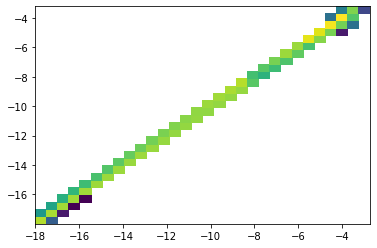

In [101]:
_ = plt.hist2d(np.log10(mod_preds_rescaled[:, 2:4].sum(axis=1)), 
           np.log10(out_test_data_rescaled[:, 0:2].sum(axis=1)), 
           bins=30,
           norm=LogNorm(), cmin=1)